In [1]:
import pandas as pd
df = pd.read_csv('Consumer_Complaints.csv')
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,03/12/2014,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,M&T BANK CORPORATION,MI,48382,NaN,NaN,Referral,03/17/2014,Closed with explanation,Yes,No,759217
1,01/19/2017,Student loan,Federal student loan servicing,Dealing with my lender or servicer,Received bad information about my loan,When my loan was switched over to Navient i wa...,NaN,"Navient Solutions, LLC.",LA,NaN,NaN,Consent provided,Web,01/19/2017,Closed with explanation,Yes,No,2296496
2,04/06/2018,Credit card or prepaid card,General-purpose credit card or charge card,"Other features, terms, or problems",Other problem,I tried to sign up for a spending monitoring p...,NaN,CAPITAL ONE FINANCIAL CORPORATION,VA,NaN,Older American,Consent provided,Web,04/06/2018,Closed with explanation,Yes,NaN,2866101
3,06/08/2014,Credit card,NaN,Bankruptcy,NaN,NaN,NaN,AMERICAN EXPRESS COMPANY,ID,83854,Older American,NaN,Web,06/10/2014,Closed with explanation,Yes,Yes,885638
4,09/13/2014,Debt collection,Credit card,Communication tactics,Frequent or repeated calls,NaN,NaN,"CITIBANK, N.A.",VA,23233,NaN,NaN,Web,09/13/2014,Closed with explanation,Yes,Yes,1027760


In [2]:
df = df[pd.notnull(df['Consumer complaint narrative'])]

In [3]:
df.shape

(328266, 18)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 328266 entries, 1 to 1135450
Data columns (total 18 columns):
Date received                   328266 non-null object
Product                         328266 non-null object
Sub-product                     276093 non-null object
Issue                           328266 non-null object
Sub-issue                       222158 non-null object
Consumer complaint narrative    328266 non-null object
Company public response         158341 non-null object
Company                         328266 non-null object
State                           327052 non-null object
ZIP code                        258975 non-null object
Tags                            56701 non-null object
Consumer consent provided?      328266 non-null object
Submitted via                   328266 non-null object
Date sent to company            328266 non-null object
Company response to consumer    328262 non-null object
Timely response?                328266 non-null object
Consumer 

In [5]:
col = ['Product', 'Consumer complaint narrative']
df = df[col]

In [6]:
df.columns

Index(['Product', 'Consumer complaint narrative'], dtype='object')

In [7]:

df.columns = ['Product', 'Consumer_complaint_narrative']

In [16]:
df=df.iloc[:100000,:]

In [17]:
df['category_id'] = df['Product'].factorize()[0]
from io import StringIO
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

In [18]:
df.head()

,Product,Consumer_complaint_narrative,category_id
1,Student loan,When my loan was switched over to Navient i wa...,0
2,Credit card or prepaid card,I tried to sign up for a spending monitoring p...,1
7,Mortgage,"My mortgage is with BB & T Bank, recently I ha...",2
13,Mortgage,The entire lending experience with Citizens Ba...,2
14,Credit reporting,My credit score has gone down XXXX points in t...,3


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.Consumer_complaint_narrative).toarray()
labels = df.category_id
features.shape

(10000, 27307)

In [23]:
from  sklearn.feature_selection import chi2
import numpy as np

N = 2
for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Product))
    print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'Bank account or service':
  . Most correlated unigrams:
       . overdrawn
       . overdraft
  . Most correlated bigrams:
       . checking account
       . overdraft fees
# 'Checking or savings account':
  . Most correlated unigrams:
       . deposit
       . overdraft
  . Most correlated bigrams:
       . overdraft fees
       . checking account
# 'Consumer Loan':
  . Most correlated unigrams:
       . nissan
       . vehicle
  . Most correlated bigrams:
       . fargo dealer
       . dealer services
# 'Credit card':
  . Most correlated unigrams:
       . citi
       . card
  . Most correlated bigrams:
       . american express
       . credit card
# 'Credit card or prepaid card':
  . Most correlated unigrams:
       . rewards
       . card
  . Most correlated bigrams:
       . card xx
       . credit card
# 'Credit reporting':
  . Most correlated unigrams:
       . experian
       . equifax
  . Most correlated bigrams:
       . investigate remove
       . tax lien
# 'Credit repo

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['Consumer_complaint_narrative'], df['Product'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [25]:
print(clf.predict(count_vect.transform(["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."])))

['Debt collection']


In [26]:
df[df['Consumer_complaint_narrative'] == "This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."]

,Product,Consumer_complaint_narrative,category_id
6995,Debt collection,This company refuses to provide me verificatio...,5


In [29]:
from sklearn.svm import LinearSVC
from  sklearn.model_selection  import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

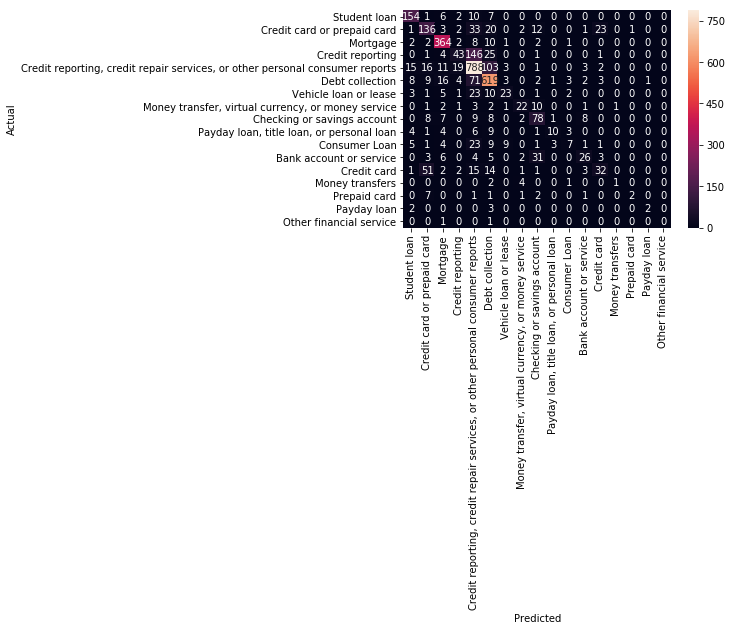

In [34]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
#fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [33]:
from IPython.display import display

for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 6:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 'Consumer_complaint_narrative']])
            print('')

'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Student loan' : 15 examples.


,Product,Consumer_complaint_narrative
17124,"Credit reporting, credit repair services, or o...",Contacted Navient concerning account that has ...
25941,"Credit reporting, credit repair services, or o...",In XX/XX/XXXX I applied for schooling thru uni...
17848,"Credit reporting, credit repair services, or o...","I recently found out that I supposedly owe 3,0..."
42716,"Credit reporting, credit repair services, or o...",I attended XXXX in XXXX XXXX that was on XXXX ...
29172,"Credit reporting, credit repair services, or o...",The reporting of student loan account number #...
46198,"Credit reporting, credit repair services, or o...",There is a student loan from XXXX in XXXX ...
18818,"Credit reporting, credit repair services, or o...",The following link proves that I am no longer ...
592,"Credit reporting, credit repair services, or o...",I just discovered this yesterday : My credit r...
2095,"Credit reporting, credit repair services, or o...",Good Day Sir/Ma'am : My circumstance does not ...
48770,"Credit reporting, credit repair services, or o...",I have student loans reporting on my credit fi...



'Debt collection' predicted as 'Student loan' : 8 examples.


,Product,Consumer_complaint_narrative
12147,Debt collection,They sent me a letter threatening to take lega...
36930,Debt collection,Phone listed is XXXX and XXXX XXXX XXXX XXXX X...
15085,Debt collection,I have student loans for which I will qualify ...
20296,Debt collection,These student loans were disputed and removed ...
9395,Debt collection,"I attended a college in XXXX, XXXX in XXXX, Fl..."
7679,Debt collection,I am paying Navient every month for mt student...
48418,Debt collection,"On Thursday, XX/XX/XXXX I receive a call from ..."
15607,Debt collection,I have three ( 3 ) PLUS loans with a standard ...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Credit card or prepaid card' : 16 examples.


,Product,Consumer_complaint_narrative
22410,"Credit reporting, credit repair services, or o...",XXXX XXXX has had a Home Depot credit card for...
43999,"Credit reporting, credit repair services, or o...",In Summer of XXXX I had fraudulent charges on ...
52100,"Credit reporting, credit repair services, or o...",I have a loan with XXXX XXXX. I have always ma...
47307,"Credit reporting, credit repair services, or o...",On XX/XX/XXXX I noticed my credit score had dr...
3986,"Credit reporting, credit repair services, or o...",I paid off this account few days back and I ad...
25207,"Credit reporting, credit repair services, or o...",I have never received a loan before by any age...
18214,"Credit reporting, credit repair services, or o...",I AM WRITING TO DISPUTE AN ACCOUNTS FRADULENTL...
20676,"Credit reporting, credit repair services, or o...",Applied for XXXX XXXX card on XX/XX/XXXX ( XXX...
12882,"Credit reporting, credit repair services, or o...",I recently settled the amount that XXXX XXXX X...
36082,"Credit reporting, credit repair services, or o...",The account isn't mine : XXXX XXXX Closed : XX...



'Debt collection' predicted as 'Credit card or prepaid card' : 9 examples.


,Product,Consumer_complaint_narrative
46035,Debt collection,I dont use credit cards and have a 800+ credit...
44643,Debt collection,Nightmare happened after I made a payment of {...
34561,Debt collection,XX/XX/XXXX XXXX payment. {$1600.00} XX/XX/XXXX...
23068,Debt collection,Purchase items from my XXXX XXXX credit card b...
29231,Debt collection,XXXX ( Seller ) breached the contract by fraud...
4633,Debt collection,I m the victim of an on-line work at home scam...
50422,Debt collection,Credit was opened with Barclays on XX/XX/XXXX ...
53616,Debt collection,I had a credit card and was not able to pay fo...
10578,Debt collection,I have an account with Credco to pull potentia...



'Checking or savings account' predicted as 'Credit card or prepaid card' : 8 examples.


,Product,Consumer_complaint_narrative
33404,Checking or savings account,The Bank of America Mobile App allows user to ...
36938,Checking or savings account,someone hacked my chase debit card in XXXX. I ...
13596,Checking or savings account,I was trying to link my Capital One account to...
54930,Checking or savings account,On XX/XX/2018 I used my debit card as a credit...
6732,Checking or savings account,I was notified of a charge to to my local XXXX...
10643,Checking or savings account,My account has been overdrawn since XX/XX/XXXX...
27008,Checking or savings account,On tuesday XX/XX/XXXX my landlord XXXX XXXX ap...
17159,Checking or savings account,I dispute balance of XX/XX/XXXX of {$940.00} f...



'Credit card' predicted as 'Credit card or prepaid card' : 51 examples.


,Product,Consumer_complaint_narrative
50695,Credit card,"Earlier this month, I received the Annual Priv..."
4506,Credit card,A XXXX gift card purchased in XXXX XXXX which ...
46500,Credit card,On XX/XX/2016 I purchased a hot water heater a...
43348,Credit card,I PURCHASED A LOVESEAT FROM XXXX AND PUT DOWN ...
22326,Credit card,"I had a Citi XXXX card. In XXXX, I charged a t..."
24998,Credit card,XX/XX/XXXX my wife had purchased a new tablet ...
3060,Credit card,XXXX Please take a look at this link above. I ...
44682,Credit card,CapitalOne Bank advertisement is false and mis...
20416,Credit card,On XXXX XXXX I received a fax through my job f...
15237,Credit card,I have been receiving mails from the Discover ...



'Prepaid card' predicted as 'Credit card or prepaid card' : 7 examples.


,Product,Consumer_complaint_narrative
44531,Prepaid card,1 hour after using Netspend 's mobile checkloa...
29181,Prepaid card,I had 3 unauthorized transfers from my America...
43738,Prepaid card,My card was used in XXXX different locations i...
23213,Prepaid card,An unauthorized charge of {$120.00} was taken ...
11822,Prepaid card,US Bank Corp denied me the ability to rescind ...
2901,Prepaid card,I 'm supposed to receive XXXX visa cards of {$...
33789,Prepaid card,"On XXXX XXXX, 2017, my card was compromised fo..."



'Student loan' predicted as 'Mortgage' : 6 examples.


,Product,Consumer_complaint_narrative
25224,Student loan,I put in an application to refinance my loan i...
50399,Student loan,ACS has been applying my entire monthly paymen...
22427,Student loan,"On XXXX XXXX, I went to studentloans.gov to co..."
52337,Student loan,"Navient is impossible to contact, and very dif..."
42459,Student loan,"Originally, I had 60 months of forbearance lef..."
29279,Student loan,"On XX/XX/2018, I submitted a payment to XXXX X..."



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Mortgage' : 11 examples.


,Product,Consumer_complaint_narrative
9355,"Credit reporting, credit repair services, or o...",AFNI has a XXXX collection against me for the ...
6531,"Credit reporting, credit repair services, or o...",Loancare continues to report my information to...
7129,"Credit reporting, credit repair services, or o...",I Leased a XXXX XXXX in XXXX and there was a p...
32814,"Credit reporting, credit repair services, or o...",I do not recall paying my M & t mortgage 30 da...
22957,"Credit reporting, credit repair services, or o...",I am writing to dispute the Mortgage Account X...
52819,"Credit reporting, credit repair services, or o...",IN XXXX XXXX I MAILED MY MORTGAGE PAYMENT TO X...
42324,"Credit reporting, credit repair services, or o...",Loan number XXXX Freedom Mortgage I have been ...
7004,"Credit reporting, credit repair services, or o...",On XX/XX/XXXX I checked my credit reports. Wel...
24572,"Credit reporting, credit repair services, or o...",I am writing to dispute the Mortgage Account X...
13276,"Credit reporting, credit repair services, or o...","Dear CFPB, These two mortgage companies report..."



'Debt collection' predicted as 'Mortgage' : 16 examples.


,Product,Consumer_complaint_narrative
39422,Debt collection,Zest cash has continually debited my account o...
46778,Debt collection,Financial Pacific Leasing 2 c ontract agreeme...
54744,Debt collection,"On or about XX/XX/XXXX, I received multiple ce..."
34501,Debt collection,GreetingsXXXX Company keeps trespassing on my ...
30937,Debt collection,Foreclosure Due to Denial Loan Modification Re...
37483,Debt collection,Nationstar Mortgage have alleged they were tra...
46206,Debt collection,SPS purchased our 2nd mortgage loan last XX/XX...
50130,Debt collection,A second mortgage was taken by myself and wif ...
9115,Debt collection,Ive been requesting a modification since XX/XX...
43440,Debt collection,Complaint Against : SELECT PORTFOLIO SERVICE X...



'Checking or savings account' predicted as 'Mortgage' : 7 examples.


,Product,Consumer_complaint_narrative
22020,Checking or savings account,Because of CFPB very primitive questionnaire o...
5289,Checking or savings account,I am seeking Deutsche Bank 's help in this ser...
45296,Checking or savings account,We renewed a CD at Wells Fargo in XX/XX/XXXX w...
39383,Checking or savings account,-XXXX I opened a brokerage account with Merril...
17068,Checking or savings account,I have been trying to close my father 's accou...
34811,Checking or savings account,Bank of America LOST MY MONEY. Despite numerou...
28343,Checking or savings account,I discovered XXXX checks from my ESCROW OVERAG...



'Bank account or service' predicted as 'Mortgage' : 6 examples.


,Product,Consumer_complaint_narrative
19674,Bank account or service,I have been refinanced my mortgage with AmeriS...
51564,Bank account or service,I applied for a home mortgage with Wells Fargo...
36514,Bank account or service,U.S. Bank debited my account incorrectly for s...
13731,Bank account or service,"My grandmother wrote me a check for XXXX, but ..."
2389,Bank account or service,The sole income I have at this time is through...
26009,Bank account or service,A refund was illegally refunded by XXXX to a c...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Credit reporting' : 19 examples.


,Product,Consumer_complaint_narrative
17125,"Credit reporting, credit repair services, or o...",Equifax continues to report a Fraudulent Colle...
38133,"Credit reporting, credit repair services, or o...","A situation has come to my attention, that nee..."
19382,"Credit reporting, credit repair services, or o...",I contacted Experian and advised them that I h...
46780,"Credit reporting, credit repair services, or o...",Equifax Confirmation Number : XXXX I am tired ...
8942,"Credit reporting, credit repair services, or o...","On XX/XX/XXXX, I found out for the first time ..."
4739,"Credit reporting, credit repair services, or o...",My credit score has always been XXXX - XXXX. T...
44802,"Credit reporting, credit repair services, or o...",I am a victim of identity theft and have been ...
29751,"Credit reporting, credit repair services, or o...",This account with XXXX was a lease. This accou...
16911,"Credit reporting, credit repair services, or o...",experian placed a fraud alert without my autho...
26388,"Credit reporting, credit repair services, or o...",I have disputed a collection on my file more t...



'Student loan' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 10 examples.


,Product,Consumer_complaint_narrative
5437,Student loan,They charge me to much when I went to the scho...
45859,Student loan,Nelnet has been double reporting my accounts f...
49850,Student loan,"Hello, There is a problem with my loans. They ..."
45047,Student loan,I am writing to dispute the following informat...
7440,Student loan,They have reported false information about my ...
45238,Student loan,I was in forbearance and they are reporting 90...
27487,Student loan,AES is reporting inaccurate information. Some...
46005,Student loan,I was an authorized user on this account. I fi...
55287,Student loan,I don't see this loan as useful anymore on my ...
25077,Student loan,They are many account open under my name and t...



'Credit card or prepaid card' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 33 examples.


,Product,Consumer_complaint_narrative
23678,Credit card or prepaid card,I sent a Goodwill letter to Capital One explai...
40984,Credit card or prepaid card,"On Friday XX/XX/2018, I conducted a conversati..."
38670,Credit card or prepaid card,We received your complaint. Thank you. \n\nWe ...
53127,Credit card or prepaid card,I have 2 credit cards with Capital one. They r...
44254,Credit card or prepaid card,Chasee refuses to remove unverified and inaccu...
46496,Credit card or prepaid card,I was an authorized user on a Fifth-Third cred...
54847,Credit card or prepaid card,There is delayed that is being reported on my ...
6016,Credit card or prepaid card,"I HAVE TWO OPEN WITH XXXX XXXX XXXX, XXXX NO.X..."
17210,Credit card or prepaid card,Ive sent letters to this company about my fami...
53823,Credit card or prepaid card,Had Fraud on my checking account for a couple ...



'Mortgage' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 8 examples.


,Product,Consumer_complaint_narrative
42865,Mortgage,My kids father told me the only way he would s...
23755,Mortgage,They have incorrect information on our transac...
15951,Mortgage,On XX/XX/XXXX I received a letter from Homepoi...
38522,Mortgage,I filed for Chapter XXXX Bankruptcy on XXXX XX...
25622,Mortgage,There are late payments on my mortgage since X...
29807,Mortgage,This complaint is in follow-up to Complaint # ...
47325,Mortgage,"I always pay early, I'm never late. I sent my ..."
423,Mortgage,We have submitted our QWR to the lender 2 time...



'Credit reporting' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 146 examples.


,Product,Consumer_complaint_narrative
37485,Credit reporting,I am filling this complaint because I have bee...
18953,Credit reporting,I complained on how the information has been r...
814,Credit reporting,I have sent several requests to Experian reque...
8085,Credit reporting,I had hired XXXX after many attempts requestin...
28904,Credit reporting,I settled with XXXX on several accounts last y...
11408,Credit reporting,Credit bureaus are reporting my former address...
42448,Credit reporting,Transunion is reporting incorrect information ...
38149,Credit reporting,XXXX XXXX XXXX account listed on my Equifax re...
12107,Credit reporting,I have repeatedly called & asked representativ...
43576,Credit reporting,This account has been disputed time and time a...



'Debt collection' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 71 examples.


,Product,Consumer_complaint_narrative
18232,Debt collection,I would like to file a formal complaint agains...
53702,Debt collection,THIS COMPANY XXXX XXXX XXXX DOES NOT HAVE AUTH...
35583,Debt collection,Capital One B account was opened in XX/XX/XXXX...
24849,Debt collection,Transunion re-inserting deleted information on...
49278,Debt collection,XXXX Statements Closing Date XX/XX/XXXX & XX/X...
46387,Debt collection,I sent a letter certified mail to Santander ma...
55560,Debt collection,My issue is with all three bureaus as well as ...
52136,Debt collection,I recently disputed the accounts listed in my ...
8229,Debt collection,I have asked real time solutions several times...
31011,Debt collection,I couldn't find the appropriate category for t...



'Vehicle loan or lease' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 23 examples.


,Product,Consumer_complaint_narrative
8531,Vehicle loan or lease,XXXX XXXX made several calls and sent two remi...
38231,Vehicle loan or lease,This all began in the middle of XX/XX/XXXX aft...
54940,Vehicle loan or lease,I called the company on XX/XX/XXXX requesting ...
1761,Vehicle loan or lease,I was going through my credit report and I not...
46469,Vehicle loan or lease,I was recently denied credit approval from Mer...
33800,Vehicle loan or lease,I bought a XXXX XXXX XXXX car from XXXX car d...
17519,Vehicle loan or lease,XXXX XXXX has consistently harrassed me when m...
13337,Vehicle loan or lease,Received an alert by email from turbo tax that...
36060,Vehicle loan or lease,I called Santander XX/XX/XXXX/to advised that ...
22853,Vehicle loan or lease,I contacted Chase Auto Finance since my report...



'Checking or savings account' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 9 examples.


,Product,Consumer_complaint_narrative
12274,Checking or savings account,XX/XX/XXXX suspected fraud activity inquiry da...
51763,Checking or savings account,My XXXX XXXX of an ex boyfriend used my debit ...
34351,Checking or savings account,I received a Fifth Third Bank promotion to ope...
32683,Checking or savings account,"I checked my balance late XXXX on XX/XX/XXXX, ..."
15519,Checking or savings account,I want early warning system to stop reporting ...
23505,Checking or savings account,Not allowing an external app to access my acco...
24686,Checking or savings account,I disputed a transaction with Wellsfargo on XX...
47342,Checking or savings account,My father passed away in XXXX. He has a POD ac...
38599,Checking or savings account,I never authorize this account to be open at n...



'Payday loan, title loan, or personal loan' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 6 examples.


,Product,Consumer_complaint_narrative
18009,"Payday loan, title loan, or personal loan",This account was opened online with a family m...
7503,"Payday loan, title loan, or personal loan",Account is closed and was paid in full. Never ...
43352,"Payday loan, title loan, or personal loan",XXXX XXXX sent me a recommendation for a debt ...
52576,"Payday loan, title loan, or personal loan",I went to this company whom I have a payday lo...
4570,"Payday loan, title loan, or personal loan",This a copy of a letter sent it to care credit...
24878,"Payday loan, title loan, or personal loan",I purchased furniture From XXXX XXXX XXXX at X...



'Consumer Loan' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 23 examples.


,Product,Consumer_complaint_narrative
45779,Consumer Loan,Our vehicle is financed through Ally Financial...
52501,Consumer Loan,The car was a voluntary repo back in 2008 and ...
22106,Consumer Loan,Houston finance has been paid off and closed s...
2619,Consumer Loan,This company submitted a fault reply to CFPB w...
47913,Consumer Loan,GM Financial is assessing a monthly {$86.00} f...
28534,Consumer Loan,Made all payments and was supposed to be remov...
32329,Consumer Loan,We leased XXXX cars from Nissan on a 39 month ...
51975,Consumer Loan,"To whom it may concern, Exeter Finance Corp is..."
41260,Consumer Loan,After a change in life circumstances and incom...
56267,Consumer Loan,I had a XXXX from Drive Time that turned out t...



'Credit card' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 15 examples.


,Product,Consumer_complaint_narrative
4814,Credit card,Was unsatisfied with the way Discover was hand...
44720,Credit card,I had a credit card with XXXX XXXX XXXX XXXX X...
32261,Credit card,**NEW INFORMATION** DUNNING LETTER DATED XX/XX...
22484,Credit card,WE HAVE SEVERAL ACCOUNT WITH THIS COMPANY WE H...
16835,Credit card,Kohls account from XXXX I was denied at the st...
30346,Credit card,I was misled into applying for PayPay Credit. ...
10016,Credit card,I had XXXX credit card accounts with HSBC. The...
51562,Credit card,American Express repeatedly makes soft credit ...
39773,Credit card,The Citi bank credit card on my credit reports...
14253,Credit card,I have received a copy of my credit report and...



'Student loan' predicted as 'Debt collection' : 7 examples.


,Product,Consumer_complaint_narrative
38590,Student loan,"In XX/XX/XXXX, XXXX XXXX started garnishing my..."
16465,Student loan,Started in XX/XX/2016 with {$220.00} payment t...
27033,Student loan,"After numerous harassing calls, I have decided..."
44401,Student loan,This company does not hold a surety bond in th...
34834,Student loan,The company called and left my husband a messa...
23944,Student loan,My sister received a call from a company calle...
22510,Student loan,I was told by XXXX that XXXX of my loans had d...



'Credit card or prepaid card' predicted as 'Debt collection' : 20 examples.


,Product,Consumer_complaint_narrative
34148,Credit card or prepaid card,I purchased a program from a company called li...
20701,Credit card or prepaid card,Minimum payments were set up on my account for...
28654,Credit card or prepaid card,"Within the past five years, I opted out of rec..."
20006,Credit card or prepaid card,XXXX XXXX states i have a refund from amer exp...
21744,Credit card or prepaid card,I was asked if I wanted a payment made. to app...
33059,Credit card or prepaid card,"My child received an offer, in his name, with ..."
50436,Credit card or prepaid card,I have been in contact with CapitalOne since e...
24803,Credit card or prepaid card,I have been getting more than 7 calls a day no...
55351,Credit card or prepaid card,I am a victim of identity theft and this accou...
52477,Credit card or prepaid card,XX/XX/2018 {$270.00} The charge was placed on ...



'Mortgage' predicted as 'Debt collection' : 10 examples.


,Product,Consumer_complaint_narrative
24154,Mortgage,Forced placed insurance
49388,Mortgage,I have repeatedly requested copies of payments...
33384,Mortgage,Ditech has served me with a summons for forecl...
14790,Mortgage,On XX/XX/2018 I was getting calls from PennyMa...
7412,Mortgage,Need to move into a XXXX facility. Can no long...
26925,Mortgage,I am filing this complaint because I were rece...
26106,Mortgage,Reopen case XXXX and XXXX. Fidelity did not se...
21127,Mortgage,This issue has been with the CFPB many times (...
53054,Mortgage,On XX/XX/XXXX I spoke to XXXX XXXX XXXX at XXX...
18149,Mortgage,Received a call from a XXXX XXXX says I owe XX...



'Credit reporting' predicted as 'Debt collection' : 25 examples.


,Product,Consumer_complaint_narrative
20941,Credit reporting,XXXX is misreporting an account I had with the...
54710,Credit reporting,XXXX with other party responsible for medical ...
24367,Credit reporting,As a private citizen I was caught up in the ex...
31036,Credit reporting,The original case number was reported in XX/XX...
43572,Credit reporting,This judgement has been vacated and needs to b...
36316,Credit reporting,"My account with XXXX, a collections agency was..."
54452,Credit reporting,EXPERIAN IS PREVENTING ME FROM BUTYING A HOUSE...
35967,Credit reporting,"Paid XXXX for 4 years, returned the car and la..."
29724,Credit reporting,I had a motorcycle stolen from me. XXXX ins pa...
30233,Credit reporting,"XXXX account # XXXX I have insurance, I paid m..."



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Debt collection' : 103 examples.


,Product,Consumer_complaint_narrative
4523,"Credit reporting, credit repair services, or o...",Several times disputing this item with your co...
52566,"Credit reporting, credit repair services, or o...",The number of times missed which is being subm...
38300,"Credit reporting, credit repair services, or o...","TO WHOM IT MAY CONCERN, I RECEIVED A LETTER IN..."
47014,"Credit reporting, credit repair services, or o...",This complaint centers around the way that som...
47918,"Credit reporting, credit repair services, or o...",As of XX/XX/XXXX I paid Chase in the final pay...
37960,"Credit reporting, credit repair services, or o...",Upon Viewing my new monitoring services i noti...
1422,"Credit reporting, credit repair services, or o...",The following account has been reported as a c...
8614,"Credit reporting, credit repair services, or o...",I contacted this agency and requested verifica...
15249,"Credit reporting, credit repair services, or o...",Portfolio Recovery Associates has been imprope...
5694,"Credit reporting, credit repair services, or o...",I just opened a XXXX XXXX and noticed Derogato...



'Vehicle loan or lease' predicted as 'Debt collection' : 10 examples.


,Product,Consumer_complaint_narrative
20143,Vehicle loan or lease,I have had lot of medical issue s and had my g...
37945,Vehicle loan or lease,"On XX/XX/XXXX at XXXX hours, the City of XXXX ..."
48482,Vehicle loan or lease,XXXX My issue with XXXX showing on my credit...
46450,Vehicle loan or lease,I have leased two Volkswagen XXXX XXXX on cons...
12756,Vehicle loan or lease,XXXX - Company Amount - {$450.00} Company sent...
31311,Vehicle loan or lease,In XXXX of XXXX I returned Toyota Camry for en...
30278,Vehicle loan or lease,XXXX XXXX XXXX - ( XXXX ) XXXX Monday XX/XX/X...
1129,Vehicle loan or lease,I have an unverified account from BRIDGECREST ...
50713,Vehicle loan or lease,Started receiving phone calls from someone nam...
12371,Vehicle loan or lease,I AM XXXX XXXX XXXX AS EX HUSBAND LAST NAME IS...



'Checking or savings account' predicted as 'Debt collection' : 8 examples.


,Product,Consumer_complaint_narrative
13744,Checking or savings account,I still have not received my bonus per the con...
36299,Checking or savings account,Contacted EverBank several times including the...
46164,Checking or savings account,I opened an account with Chase. The website ge...
12008,Checking or savings account,"I made three deposits, XXXX, XX/XX/2018, XXXX,..."
32538,Checking or savings account,I had an overdraft for a {$160.00} and paid it...
25133,Checking or savings account,my complaint is with RushCard. There was unaut...
6788,Checking or savings account,The company XXXX is n't getting the informat...
55136,Checking or savings account,Over draft fees. I was advised they could be w...



'Payday loan, title loan, or personal loan' predicted as 'Debt collection' : 9 examples.


,Product,Consumer_complaint_narrative
36770,"Payday loan, title loan, or personal loan",Ad astra recovery is listed on all XXXX of...
47459,"Payday loan, title loan, or personal loan",I got notice to vacate the house I was renting...
23888,"Payday loan, title loan, or personal loan",I made a loan 15 years ago to finance a boat w...
12791,"Payday loan, title loan, or personal loan",They did n't tell me that they was going to ch...
23865,"Payday loan, title loan, or personal loan",It shows in my credit report that I owe XXXX X...
40935,"Payday loan, title loan, or personal loan",Received call today from Niagra Restitution Se...
15099,"Payday loan, title loan, or personal loan",I purchased a clothes dryer from XXXX XXXX XXX...
49326,"Payday loan, title loan, or personal loan",XXXX XXXX keeps calling and emailing me saying...
48730,"Payday loan, title loan, or personal loan",The company refuses to work with me after cont...



'Consumer Loan' predicted as 'Debt collection' : 9 examples.


,Product,Consumer_complaint_narrative
2420,Consumer Loan,Santander accepted a settlement after an auto ...
27142,Consumer Loan,i submitted a complain 2 days ago about this c...
39062,Consumer Loan,I had sent the company Ace Cash Express a lett...
19431,Consumer Loan,hi my problem is i took out a loan with las ve...
23490,Consumer Loan,I am on social security XXXX and when I took o...
55192,Consumer Loan,I have been sued and a judgement against me. I...
32537,Consumer Loan,"Back in and around XX/XX/XXXX, My spouse and I..."
35324,Consumer Loan,On XXXX/XXXX/15 money was taking out automatic...
14342,Consumer Loan,AutoCredit and MG Finance refuse to remove pai...



'Credit card' predicted as 'Debt collection' : 14 examples.


,Product,Consumer_complaint_narrative
52685,Credit card,This debt has been on my report for over 10 ye...
37604,Credit card,I tried using XXXX internet but because of my ...
41271,Credit card,I would like to file a complaint with Consumer...
45269,Credit card,This is not my account yet the company keeps c...
26647,Credit card,In XX/XX/XXXX I received an alarming call from...
38700,Credit card,This is a follow up to my earlier complaint I ...
21963,Credit card,At the time of my divorce the judge ordered my...
48650,Credit card,I was notified by Citibank that my universal c...
19441,Credit card,I noticed XXXX fradulent charges on my account...
49533,Credit card,I have been set up for payment reminders and o...



'Consumer Loan' predicted as 'Vehicle loan or lease' : 9 examples.


,Product,Consumer_complaint_narrative
21198,Consumer Loan,XX/XX/XXXX I leased a Nissan Leaf ( all-electr...
42826,Consumer Loan,Santander!!!!!! My mother has been dealing wit...
17526,Consumer Loan,Lender illegal reported to my credit as a auto...
36498,Consumer Loan,GM Financial is reporting an old debt on my cr...
52781,Consumer Loan,I had an auto loan as a co borrower with Santa...
16007,Consumer Loan,Mercedes Benz Financial was notified on or abo...
4393,Consumer Loan,Toyota Financial Services makes it extremely d...
30552,Consumer Loan,This issues pertains to a late payment incurre...
35264,Consumer Loan,I had a car loan with Santander Consumer USA. ...



'Credit card or prepaid card' predicted as 'Checking or savings account' : 12 examples.


,Product,Consumer_complaint_narrative
49440,Credit card or prepaid card,On XX/XX/XXXX my XXXX account was hacked and I...
1149,Credit card or prepaid card,Fax XXXX XXXX XXXX Account Manager XXXX XXXX. ...
45944,Credit card or prepaid card,XX/XX/2018 XXXX XXXX XXXX XXXX XXXX XXXX XXXX ...
31809,Credit card or prepaid card,I opened up a XXXX XXXX rewards prepaid card ....
17570,Credit card or prepaid card,"XXXX XXXX $ {$990.00} ( police report made, pe..."
17641,Credit card or prepaid card,On XX/XX/XXXX I authorized a check with Bluebi...
3111,Credit card or prepaid card,Chase Freedom misrepresented crucial acts of t...
25608,Credit card or prepaid card,i opened a tjx rewards card which is handled t...
23058,Credit card or prepaid card,Capital One is blocking me from viewing my bal...
12479,Credit card or prepaid card,see complaint # XXXX when I logged into my a...



'Money transfer, virtual currency, or money service' predicted as 'Checking or savings account' : 10 examples.


,Product,Consumer_complaint_narrative
26880,"Money transfer, virtual currency, or money ser...",XX/XX/XXXX - Due to increased costs for my mom...
34433,"Money transfer, virtual currency, or money ser...",On XX/XX/XXXX I issued a wire transfer in the ...
46970,"Money transfer, virtual currency, or money ser...",Bank will not allow access or app is not allow...
27765,"Money transfer, virtual currency, or money ser...",I have filed XXXX previous complaints. I wan...
21113,"Money transfer, virtual currency, or money ser...",Ive recently discovered 2 Cashier Checks dated...
2761,"Money transfer, virtual currency, or money ser...",My employer does not offer direct deposit. Eve...
24281,"Money transfer, virtual currency, or money ser...",On XX/XX/2017 I sent a XXXX payment for {$1100...
31237,"Money transfer, virtual currency, or money ser...",I do n't know why it keep saying they ca n't c...
55236,"Money transfer, virtual currency, or money ser...","I applied for loans online, a company named Ca..."
53963,"Money transfer, virtual currency, or money ser...","purchased bitcoin using this merchant XAPO, re..."



'Bank account or service' predicted as 'Checking or savings account' : 31 examples.


,Product,Consumer_complaint_narrative
27515,Bank account or service,After closing a Bank of America CD and transfe...
13621,Bank account or service,On or about XXXX/XXXX/15 PNC Bank charged our ...
37664,Bank account or service,Citibank Texas NA was sold to XXXX XXXX XXXX o...
55189,Bank account or service,I opened a PNC bank account online. They verif...
15039,Bank account or service,This company said they will close my account f...
29060,Bank account or service,"I had a business account with citibank, which ..."
32280,Bank account or service,I have never opted in to any fee agreement wit...
15795,Bank account or service,"Beginning in XXXX of XXXX, I had an invoice sh..."
5065,Bank account or service,Dear CFPB : The ONLY Bank of America office an...
28883,Bank account or service,My XXXX yr old son opened an account at age XX...



'Checking or savings account' predicted as 'Bank account or service' : 8 examples.


,Product,Consumer_complaint_narrative
44652,Checking or savings account,On XXXX XXXX 2017 around XXXX to XXXX I visite...
50266,Checking or savings account,"Wells Fargo Bank, has decided on their own to ..."
29776,Checking or savings account,On XXXX/XXXX/XXXX My checking account with Nav...
17249,Checking or savings account,I have had a fraudulent charge on my account a...
9771,Checking or savings account,I received letters dated XXXX XXXX from Wells ...
49958,Checking or savings account,I responded to a banner ad from US Bank to ope...
25604,Checking or savings account,My debit card information was taken and used i...
24640,Checking or savings account,I currently bank with Navy Federal Credit Unio...



'Credit card or prepaid card' predicted as 'Credit card' : 23 examples.


,Product,Consumer_complaint_narrative
40989,Credit card or prepaid card,"XX/XX/2013, {$9100.00}, This is a Chase Bank c..."
55780,Credit card or prepaid card,I noticed there were interest charges on my cr...
7982,Credit card or prepaid card,On X/XX/2017 I received an email from Chas...
32570,Credit card or prepaid card,I tried to pay my walmart Mastercard monthly b...
42537,Credit card or prepaid card,I called to make a payment for my Total Visa C...
42926,Credit card or prepaid card,I have a Macy 's credit card and I paid my out...
54961,Credit card or prepaid card,I have a Visa credit card with Bank of America...
11689,Credit card or prepaid card,I just returned from a XXXX on the XXXX XXXX a...
7848,Credit card or prepaid card,A fraudulent charge was made to my credit card...
3338,Credit card or prepaid card,I paid XXXX XXXX a deposit via opening a Care ...


In [35]:
model.fit(features, labels)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [36]:
from sklearn.feature_selection import chi2

N = 2
for Product, category_id in sorted(category_to_id.items()):
    indices = np.argsort(model.coef_[category_id])
      feature_names = np.array(tfidf.get_feature_names())[indices]
      unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
      bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
      print("# '{}':".format(Product))
      print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
      print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'Bank account or service':
  . Top unigrams:
       . bank
       . overdrawn
  . Top bigrams:
       . line credit
       . personal account
# 'Checking or savings account':
  . Top unigrams:
       . overdraft
       . bank
  . Top bigrams:
       . debit card
       . capital 360
# 'Consumer Loan':
  . Top unigrams:
       . loan
       . nissan
  . Top bigrams:
       . history xxxx
       . 2600 00
# 'Credit card':
  . Top unigrams:
       . card
       . discover
  . Top bigrams:
       . best buy
       . faxed copy
# 'Credit card or prepaid card':
  . Top unigrams:
       . card
       . merchant
  . Top bigrams:
       . card xx
       . theft account
# 'Credit reporting':
  . Top unigrams:
       . transunion
       . experian
  . Top bigrams:
       . unauthorized fraudulent
       . investigate remove
# 'Credit reporting, credit repair services, or other personal consumer reports':
  . Top unigrams:
       . report
       . reporting
  . Top bigrams:
       . xxxx xxxx
  

In [37]:
texts = ["I requested a home loan modification through Bank of America. Bank of America never got back to me.",
         "It has been difficult for me to find my past due balance. I missed a regular monthly payment",
         "I can't get the money out of the country.",
         "I have no money to pay my tuition",
         "Coinbase closed my account for no reason and furthermore refused to give me a reason despite dozens of request"]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

"I requested a home loan modification through Bank of America. Bank of America never got back to me."
  - Predicted as: 'Mortgage'

"It has been difficult for me to find my past due balance. I missed a regular monthly payment"
  - Predicted as: 'Mortgage'

"I can't get the money out of the country."
  - Predicted as: 'Debt collection'

"I have no money to pay my tuition"
  - Predicted as: 'Debt collection'

"Coinbase closed my account for no reason and furthermore refused to give me a reason despite dozens of request"
  - Predicted as: 'Money transfer, virtual currency, or money service'



In [38]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=df['Product'].unique()))

C:\Anaconda3-5.0.1\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                                                                              precision    recall  f1-score   support

                                                                Student loan       0.79      0.86      0.82       180
                                                 Credit card or prepaid card       0.57      0.58      0.58       234
                                                                    Mortgage       0.84      0.93      0.88       392
                                                            Credit reporting       0.57      0.19      0.29       221
Credit reporting, credit repair services, or other personal consumer reports       0.69      0.82      0.75       961
                                                             Debt collection       0.73      0.83      0.78       742
                                                       Vehicle loan or lease       0.57      0.33      0.42        69
                          Money transfer, virtual curre